In [96]:
import warnings
warnings.filterwarnings('ignore')

In [474]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as ss
from sklearn.base import BaseEstimator
import inspect
from collections import Counter
from sklearn.metrics import make_scorer,recall_score,roc_auc_score,plot_confusion_matrix,f1_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression,SGDClassifier,HuberRegressor,RANSACRegressor,TheilSenRegressor
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,IsolationForest,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC,OneClassSVM
from sklearn.model_selection import RepeatedKFold,RepeatedStratifiedKFold,cross_val_score,cross_validate,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.cluster import MeanShift
from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler,NearMiss,TomekLinks,ClusterCentroids,EditedNearestNeighbours,NeighbourhoodCleaningRule
from imblearn.datasets import make_imbalance
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,clone
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.preprocessing import RobustScaler,StandardScaler,LabelEncoder
import time
from cleanlab.classification import LearningWithNoisyLabels
from cleanlab.noise_generation import generate_noise_matrix_from_trace
from cleanlab.noise_generation import generate_noisy_labels
from cleanlab.util import print_noise_matrix
import copy
from skclean.models import RobustLR,RobustForest
from skclean.simulate_noise import UniformNoise
from sklearn.neighbors import KNeighborsClassifier,DistanceMetric
from sklearn.svm import SVC
import eif as eif
from sklearn.impute import SimpleImputer
from skclean.detectors import MCS

In [465]:
from pyod.models.pca import PCA
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.lof import LOF
from pyod.models.cblof import CBLOF
from pyod.models.knn import KNN
from pyod.models.hbos import HBOS
from pyod.models.abod import ABOD
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.lscp import LSCP
from pyod.models.lmdd import LMDD
from pyod.models.copod import COPOD
from pyod.models.sos import SOS
from pyod.models.sod import SOD
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL


## Importation Données

In [5]:
df = pd.read_csv('wisconsin.csv',sep=',')
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,S
0,16,5,1,1,1,2,1,3,1,1,2
1,41,5,4,4,5,7,10,3,2,1,2
2,15,3,1,1,1,2,2,3,1,1,2
3,41,6,8,8,1,3,4,3,7,1,2
4,17,4,1,1,3,2,1,3,1,1,2


In [6]:
# Division en Features & Labels - Versions sans bruit
dfVal = df.values
X_clean, y_clean = dfVal[:, :-1], dfVal[:, -1]
print('Format Features:{} ; Format Labels:{}'.format(X_clean.shape,y_clean.shape))

Format Features:(663, 10) ; Format Labels:(663,)


## Baseline - Clean Data 

In [88]:
# On instancie l'objet cross-validation avec stratification et répétition
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# On instancie le modèle
cv_clean_y = cross_validate(LogisticRegression(random_state=1), X_clean, y_clean, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                            cv=cv, n_jobs=-1,return_estimator=True,return_train_score=True)
# On récupère les scores au pluriel puisque nous validons sur plusieurs vagues et on moyenne sur ces différents scores
print('Testing Accuracy: %.4f ; Training Accuracy: %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_clean_y['test_accuracy']),
                                                               np.mean(cv_clean_y['train_accuracy']),
                                                               np.mean(cv_clean_y['test_roc_auc'])))

Testing Accuracy: 0.9679 ; Training Accuracy: 0.9713 ; Roc_Auc: 0.9638 


## Métrique utilisé - ELA

L'<b>Equalized Loss of Accuracy</b> est proposée par Sáez et al. et combine la robustesse et un facteur dépendant de la précision initiale. Cette mesure tente de minimiser les problèmes liés à l'examen individuel des mesures de performance et de robustesse et peut être utilisée pour comparer facilement différents classificateurs [1].  La mesure de l'ELA est :<br>
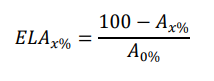 <br>
où $A_{x\%}$ est l'accuracy au niveau de bruit $x\%$ et $A_{0\%}$ est l'accuracy au niveau sans bruit. <br>



[1]: J. A. Sáez, J. Luengo, and F. Herrera, “Evaluating the classifier behavior with noisy data considering performance
and robustness: The Equalized Loss of Accuracy measure”ELSEVIER, Neurocomputing 176 (2016) 26-35. 

In [81]:
#Implémentation
def ELA(est):
    return (1-np.mean(est['test_accuracy']))/np.mean(cv_clean_y['test_accuracy'])

## Introduction de bruit uniforme

Corruption/erreur représentée dans les valeurs d'attribut des instances dans un ensemble de données est appelé bruit d'attribut: les valeurs d'attribut erronées,manquantes, inconnues ou incomplètes. Des efforts de recherche ont été entrepris pour traiter du bruit d'attribut et l'élimination est l'un des moyens couramment utilisés.<br>
Toutefois, leurs résultats montrent que l'élimination des cas contenant le bruit d'attribut n'est pas une bonne idée, car pouvant contenir de l'information . Par conséquent, le traitement du bruit d'attributest plus difficile et la recherche dans ce domaine n'a pas beaucoup de progrès, à l'exception de quelques efforts<br> 
On essaiera de traiter ce cas par la suite

Afin de pouvoir contrôler le niveau de bruit dans l'ensemble de données, nous avons ajouté manuellement x% de bruit dans l'ensemble de données en changeant aléatoirement les labels de classe d'exactement x% des instances par d'autres classes. 

In [82]:
X_dirty,y_dirty=UniformNoise(noise_level=0.2 # Bruit 20%
                             ,random_state=1).fit_transform(X_clean.copy(),y_clean.copy())
print(Counter(y_dirty))

Counter({2: 410, 4: 253})


In [10]:
print(Counter(y_clean))

Counter({2: 434, 4: 229})


In [89]:
# On instancie l'objet cross-validation avec stratification et répétition
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
etapes = [('StandardScaling',  StandardScaler()),
    ('modele',LogisticRegression(C=0.1,random_state=1,solver='saga',penalty='l1'))]
pipeline = Pipeline(steps=etapes)
# On instancie le modèle
cv_logreg_y = cross_validate(pipeline, X_dirty, y_dirty, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                            cv=cv, n_jobs=-1,return_estimator=True,return_train_score=True)
# On récupère les scores au pluriel puisque nous validons sur plusieurs vagues et on moyenne sur ces différents scores
print('Testing Accuracy: %.4f ; Training Accuracy: %.4f ; Roc_Auc: %.4f, ELA: %.4f' % (np.mean(cv_logreg_y['test_accuracy']),
                                                               np.mean(cv_logreg_y['train_accuracy']),
                                                               np.mean(cv_logreg_y['test_roc_auc']),
                                                               ELA(cv_logreg_y)))

Testing Accuracy: 0.7667 ; Training Accuracy: 0.7731 ; Roc_Auc: 0.7362, ELA: 0.2411


# Apprentissage supervisé


## Algorithmes robustes

#### Remaque : Robuste signifie résistant aux outliers

###  MOM

De nombreux algorithmes d'apprentissage sont basés sur un paradigme connu sous le nom de minimisation du risque empirique/empirical risk minimization (ERM)  qui consiste à trouver l'estimateur $\widehat{f}$ qui minimise une estimation du risque.<br>
<h3><center> $\widehat{f} = \text{argmin}_{f\in F}\frac{1}{n}\sum_{i=1}^n\ell(f(X_i),y_i),$</center></h3>
où le $\ell$ est une fonction de perte (par exemple la distance au carré dans les problèmes de régression). Autrement dit, nous essayons de minimiser une estimation du risque attendu et cette estimation correspond à une moyenne empirique. Cependant, il est bien connu que la moyenne empirique n'est pas robuste aux données extrêmes et ces valeurs extrêmes auront une grande influence sur l'estimation de $\widehat{f}$  . Le principe de l'algorithme de pondération robuste est de s'appuyer sur un estimateur robuste (tel que la Mean-of-Medians (MOM) ou le Huber Estimator au lieu de la moyenne empirique dans l'équation ci-dessus <br>
En pratique, on peut définir des poids $w_i$ qui dépendent du $i^{ème}$ échantillon, le poids $w_i$ étant très faible lorsque la $i^{ème}$ donnée  est aberrante et important dans le cas contraire. De cette façon, le problème est réduit à l'optimisation suivante :<br>
<h3><center> $\min_{f}\, \frac{1}{n} \sum_{i=1}^n w_i\ell(f(X_i),y_i)$</center></h3> <br>

Ref:[Guillaume Lecué, Matthieu Lerasle and Timothée Mathieu. “Robust classification via MOM minimization”, Machine Learning Journal (2020)]

L'approche est mise en œuvre sous la forme d'un méta-algorithme qui prend comme entrée un estimateur de base<br>
À chaque étape, l'algorithme estime les poids d'échantillon qui sont censés être petits pour les valeurs aberrantes et grands pour les valeurs incrustées, puis nous effectuons une étape d'optimisation en utilisant l'algorithme d'optimisation de l'estimateur de base.<br>
Cet algorithme prend en charge deux schémas de pondération : Les poids de type Huber et les poids de la MoM. 

<b>Median-of-means weights:</b> le paramètre "k" est un entier non négatif, lorsque k=0 l'estimateur est exactement le même que l'estimateur de base et lorsque k=taille_de_l'échantillon/2 l'estimateur est très robuste mais moins efficace sur les inliers. Une bonne heuristique consiste à choisir k comme estimation du nombre d'observations aberrantes. En pratique, si k=Nul, il est estimé en utilisant le nombre de points éloignés de la médiane de plus de 1,45 fois l'intervalle interquartile.

In [84]:
#Robust
#Median of Means
#Implémentation inspirée par:
#[Stanislav Minsker and Timothée Mathieu. “Excess risk bounds in robust empirical risk minimization” arXiv preprint (2019). arXiv:1910.07485.]
#[https://github.com/lecueguillaume]
# Modifié pour Projet PIST par KERMADI ZIAD

def blockMOM(K,x):
    '''Sample the indices of K blocks for data x using a random permutation
    Parameters
    ----------
    K : int
        number of blocks
    x : array like, length = n_sample
        sample whose size correspong to the size of the sample we want to do blocks for.
    Returns 
    -------
    list of size K containing the lists of the indices of the blocks, the size of the lists are contained in [n_sample/K,2n_sample/K]
    '''
    b=int(np.floor(len(x)/K))
    nb=K-(len(x)-b*K)
    nbpu=len(x)-b*K
    perm=np.random.permutation(len(x))
    blocks=[[(b+1)*g+f for f in range(b+1) ] for g in range(nbpu)]
    blocks+=[[nbpu*(b+1)+b*g+f for f in range(b)] for g in range(nb)]
    return [perm[b] for  b in blocks]

def MOM(x,blocks):
    '''Compute the median of means of x using the blocks 
    Parameters
    ----------
    x : array like, length = n_sample
        sample from which we want an estimator of the mean
    blocks : list of list, provided by the function blockMOM.
    Return
    ------
    The median of means of x using the block blocks, a float.
    '''
    means_blocks=[np.mean([ x[f] for f in ind]) for ind in blocks]
    indice=np.argsort(means_blocks)[int(np.ceil(len(means_blocks)/2))]
    return means_blocks[indice],indice

class logregMOM_binary(BaseEstimator):
    '''Class of the binary classification for the logistic regression MOM.
    
    Parameters
    ----------
    w0 : array-like, length = n_features + 1, default ones(n_features + 1)
        initial coefficients (including the intercept) of the classifier.
    K : int, default 10
        number of blocks for the computation of the MOM. A big value of K deals with more outliers but small values of K are better for the performance when there are no outliers.
        
    eta0 : float, default 1
        step size parameter, the step size is defined as the i-th iteration by 1/(1+eta0*i).
    beta : float, default 1
        L2 regularization parameter.
    epoch : int, default 200
        number of iterations before the end of the algorithm.
    agg : int, default 3
        number of runs of the algorithm on which we aggregate. One might want to decrease this number if the complexity is a problem.
    compter : boolean, default False
        used for outlier detection, if compter=True, the number of time each point is used in the algorithm will be recorded in the attribute "counts".
    progress : boolean, default False
        display a progress bar to monitor the algorithm on each run (agg > 1 means several progress bar).
    verbose : boolean, default True
        display a message at the end of each run if agg > 1.
    multi : {'ovr','ovo'} , default 'ovr'
        method used to go from binary classification to multiclass classification. 'ovr' means "one vs the rest" and 'ovo' means "one vs one" .
        
    Attributes
    ----------
    
    w0 : array like, length = n_features + 1
        w0 is updated in the algorithm, provides with the final coefficients of the decision function.
    counts : array like, length = n_sampled
        the i-th element record the number of time the i-th element of the training dataset X has been used. Only if compter=True.
    Methods
    -------
    fit(X,y) : fit the model
        X : numpy matrix size = (n_samples,n_features)
        y : array like, length = n_samples
    predict(X) : predict the class of the points in X
        X : numpy matrix size = (n_samples,n_features)
        returns array-like, length = n_samples.
    predict_proba(X) : predict the probability that each point belong to each class.
        X : numpy matrox size = (n_samples,n_features)
        returns matrix, size = (n_samples,n_class)
     '''   
    def __init__(self,w0=None,K=10,eta0=1,beta=1,epoch=200,agg=3,compter=False,progress=False,verbose=True,power=2/3):
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
    def fit1(self,x,Y):
        w=np.array(self.w0)
        X=np.hstack([np.array(x),np.ones(len(x)).reshape(len(x),1)])

        pas=lambda i : 1/(1+self.eta0*i)**self.power
        if self.compter:
            self.counts=np.zeros(len(X))
        compteur=1
        fincompteur=1
        if self.progress:
            Bar=progressbar(self.epoch)
        for f in range(self.epoch):
            if self.progress:
                Bar.update(f)
            losses=self.perte(X,Y,w)
            blocks=blockMOM(self.K,X)

            compteur+=1
            risque,b=MOM(losses,blocks)
            Xb=X[blocks[b]]
            yb=Y[blocks[b]]
            #IRLS avec regularisation L2
            eta=self.sigmoid(Xb.dot(w.reshape([len(w),1]))).reshape(len(Xb))
            D=np.diag(eta*(1-eta))
            w=w*(1-pas(f))+pas(f)*np.linalg.inv(np.transpose(Xb).dot(D).dot(Xb)+self.beta*np.eye(len(X[0]))).dot(np.transpose(Xb).dot(yb-eta)-self.beta*w)
            if self.compter:
                self.counts[blocks[b]]+=1

            
        return w

    def fit(self,x,Y):
        if self.w0 is None:
            self.w0=np.zeros(len(x[0])+1)
        y=np.array(Y).copy()
        self.values=np.sort(list(set(Y)))
        yj=y.copy()
        indmu=yj!=self.values[1]
        indu=yj==self.values[1]
        yj[indmu]=0
        yj[indu]=1
        w=np.zeros(len(self.w0))
        for f in range(self.agg):
            if self.agg !=1 and self.verbose:
                print('Passage '+str(f))
            w+=self.fit1(x,yj)
        self.w=w/self.agg

    def perte(self,X,y,w):
        pred=X.dot(w.reshape([len(w),1]))
        pred=pred.reshape(len(X))
        return np.log(1+np.exp(-(2*y-1)*pred))

    def predict(self,x):
        X=x.copy
        X=np.hstack([x,np.ones(len(x)).reshape(len(x),1)])

        pred=(X.dot(self.w.reshape([len(self.w),1]))).reshape(len(X))
        return np.array([self.values[int(p>0)] for p in pred])

    def predict_proba(self,x):
        X=x.copy
        X=np.hstack([x,np.ones(len(x)).reshape(len(x),1)])
        pred=self.sigmoid(X.dot(self.w.reshape([len(self.w)])))
        return np.array([[1-p,p] for p in pred])

    def sigmoid(self,x):
        return 1/(1+np.exp(-x))

    def score(self,x,y):
        pred=self.predict(x)
        return np.mean(pred==np.array(y))

<b>=> max_iter & eta0</b> sont des choix importants et je devrais mettre un cvgridsearch pour leur tuning mais on diffère cet exercice pour un autre temps ( Il est 5h du matin ^^ )<br>
<b>=> Epoch</b> plus grande donne des résultats meilleurs mais dans plus de temps<br>
<b>=> </b>Puisque cet algorithme a une loss function à base de calcul distanciel:Le <b>Scaling</b> des données est important et on fait donc un Scaling robuste des données avec RobustScaler
<b>=> </b>Il est conseillé de choisir <b>K </b> tel que le nombre d'outliers si on les connait

In [90]:
#Application
etapes = [('RobustScaling',  RobustScaler()), ('modele',logregMOM_binary(K=int(y_dirty.shape[0]*0.2)+17,epoch=500))]
pipeline = Pipeline(steps=etapes)
cv_logreg_mom_y_scaled = cross_validate(pipeline,X_dirty, LabelEncoder().fit_transform(y_dirty), scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Testing Accuracy: %.4f ; Training Accuracy: %.4f ; Roc_Auc: %.4f, ELA: %.4f' % (np.mean(cv_logreg_mom_y_scaled['test_accuracy']),
                                                               np.mean(cv_logreg_mom_y_scaled['train_accuracy']),
                                                               np.mean(cv_logreg_mom_y_scaled['test_roc_auc']),
                                                               ELA(cv_logreg_mom_y_scaled)))

Testing Accuracy: 0.7752 ; Training Accuracy: 0.7769 ; Roc_Auc: 0.7531, ELA: 0.2323


##  Huber 

In [212]:
#Application
#TypeError: cleanlab requires zero-indexed labels (0,1,2,..,m-1), but in your case: np.unique(s) = [2 4] --> On utilise LabelEncoder

etapes = [('RobustScaling',  RobustScaler()),
          ('modele',SGDClassifier(loss="huber",alpha=0.001,random_state=1,penalty='l1',class_weight='balanced',epsilon=0.3))]
pipeline = Pipeline(steps=etapes)
cv_logreg_huber_y_scaled = cross_validate(pipeline,X_dirty, y_dirty, scoring={
                                                       'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Testing Accuracy: %.4f ; Training Accuracy: %.4f ; Roc_Auc: %.4f, ELA: %.4f' % (np.mean(cv_logreg_huber_y_scaled['test_accuracy']),
                                                               np.mean(cv_logreg_huber_y_scaled['train_accuracy']),
                                                               np.mean(cv_logreg_huber_y_scaled['test_roc_auc']),
                                                               ELA(cv_logreg_huber_y_scaled)))

Testing Accuracy: 0.7787 ; Training Accuracy: 0.7729 ; Roc_Auc: 0.7516, ELA: 0.2286


###  Confident Learning

Le CL s'appuie sur les principes développés dans la littérature traitant des étiquettes bruyantes :

><b>Pruning</b> pour rechercher les erreurs d'étiquetage, par exemple en suivant l'exemple de Natarajan et al. (2013) ; van Rooyen et al. (2015) ; Patrini et al. (2017), en utilisant un élagage doux via une repondération des pertes, pour éviter les pièges de convergence d'un réétiquetage itératif<br>
><b>Counting</b> pour s'entraîner sur des données propres, en évitant la propagation d'erreurs dans les poids de modèle appris par la repondération de la perte (Natarajan et al., 2017) avec des probabilités prédites imparfaites, en généralisant les travaux fondateurs Forman (2005, 2008) ; Lipton et al. (2018).<br>
><b>Ranking</b> pour classer les exemples à utiliser pendant la formation, pour permettre l'apprentissage avec des probabilités non normalisées ou des distances aux limites de décision du MVC, en s'appuyant sur les résultats de robustesse bien connus de PageRank (Page et al., 1997) et sur les idées d'apprentissage de programmes dans MentorNet (Jiang et al.,2018).

In [ ]:
# Application avec Regression logistique comme estimateur de base

In [119]:
#Application avec Pruning par ratio de bruit -->  works by removing examples with
        #*high probability* of being mislabeled for every non-diagonal in the `prune_counts_matrix`
    
conf = LearningWithNoisyLabels(clf=LogisticRegression(C=0.1),cv_n_folds=10,seed=1).fit(X_dirty,LabelEncoder().fit_transform(y_dirty))
conf_test_accu=conf.score(X_dirty,LabelEncoder().fit_transform(y_dirty)) # Score Accuracy du Test
conf_roc_auc=roc_auc_score(LabelEncoder().fit_transform(y_dirty),conf.predict(X_dirty)) # Score roc_auc
conf_ela=1-conf_test_accu/np.mean(cv_clean_y['test_accuracy']) # Score ELA

print('Testing Accuracy: %.4f ; Roc_Auc: %.4f, ELA: %.4f' % (conf_test_accu,
                                                               conf_roc_auc,
                                                               conf_ela))

Testing Accuracy: 0.7858 ; Roc_Auc: 0.7633, ELA: 0.1881


In [120]:
#Application avec Pruning par classe --> works by removing the examples with *smallest
       # probability* of belonging to their given class label for every class
conf_c = LearningWithNoisyLabels(clf=LogisticRegression(C=0.1),cv_n_folds=10,seed=1,prune_method='prune_by_class').fit(X_dirty,LabelEncoder().fit_transform(y_dirty))
conf_c_test_accu=conf_c.score(X_dirty,LabelEncoder().fit_transform(y_dirty))
conf_c_roc_auc=roc_auc_score(LabelEncoder().fit_transform(y_dirty),conf_c.predict(X_dirty))
conf_c_ela=1-conf_c_test_accu/np.mean(cv_clean_y['test_accuracy'])

print('Testing Accuracy: %.4f ; Roc_Auc: %.4f, ELA: %.4f' % (conf_c_test_accu,
                                                               conf_c_roc_auc,
                                                               conf_c_ela))

Testing Accuracy: 0.7858 ; Roc_Auc: 0.7633, ELA: 0.1881


In [ ]:
# application avec RF comme estimateur de base

In [84]:
conf_rf = LearningWithNoisyLabels(clf=RandomForestClassifier(),cv_n_folds=10,seed=1).fit(X_dirty,LabelEncoder().fit_transform(y_dirty))
conf_rf_test_accu=conf_rf.score(X_dirty,LabelEncoder().fit_transform(y_dirty))
conf_rf_roc_auc=roc_auc_score(LabelEncoder().fit_transform(y_dirty),conf_rf.predict(X_dirty))
conf_rf_ela=1-conf_rf_test_accu/np.mean(cv_clean_y['test_accuracy'])

print('Testing Accuracy: %.4f ; Roc_Auc: %.4f, ELA: %.4f' % (conf_rf_test_accu,
                                                               conf_rf_roc_auc,
                                                               conf_rf_ela))

Testing Accuracy: 0.7994 ; Roc_Auc: 0.7826, ELA: 0.1741


### RobustLR

Modifies the logistic loss using class dependent (estimated) noise rates for robustness. This implementation is for binary classification tasks only.

In [160]:
#Application
#On utilise LabelEncoder

etapes = [('StandardScaling',  StandardScaler()),
    ('modele',RobustLR(NP=0,PN=0.2 ,random_state=1 ))]
pipeline = Pipeline(steps=etapes)
cv_logreg_rob_y_scaled = cross_validate(pipeline,X_dirty,LabelEncoder().fit_transform(y_dirty), scoring={
                                                       'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Testing Accuracy: %.4f ; Training Accuracy: %.4f ; Roc_Auc: %.4f, ELA: %.4f' % (np.mean(cv_logreg_rob_y_scaled['test_accuracy']),
                                                               np.mean(cv_logreg_rob_y_scaled['train_accuracy']),
                                                               np.mean(cv_logreg_rob_y_scaled['test_roc_auc']),
                                                               ELA(cv_logreg_rob_y_scaled)))

Testing Accuracy: 0.7777 ; Training Accuracy: 0.7833 ; Roc_Auc: 0.7608, ELA: 0.2296


### RandomForest

In [272]:
#Application
etapes = [ ('modele',RandomForestClassifier(n_estimators=301,
                                             random_state=1,
                                   class_weight='balanced'
                                   ,max_features=3
                                   ,max_depth=5
                                   ,min_samples_leaf=2))]
pipeline = Pipeline(steps=etapes)
cv_r = cross_validate(pipeline,X_dirty, LabelEncoder().fit_transform(y_dirty), scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Testing Accuracy: %.4f ; Training Accuracy: %.4f ; Roc_Auc: %.4f, ELA: %.4f' % (np.mean(cv_r['test_accuracy']),
                                                               np.mean(cv_r['train_accuracy']),
                                                               np.mean(cv_r['test_roc_auc']),
                                                               ELA(cv_r)))

Testing Accuracy: 0.7863 ; Training Accuracy: 0.7979 ; Roc_Auc: 0.7689, ELA: 0.2208


La RF hérite son insensibilité aux valeurs aberrantes du cloisonnement récursif et de l'ajustement des modèles localement(les leafs).

### RobustRF

Uses a random forest to to compute pairwise similarity/distance, and then a simple K Nearest Neighbor that works on that similarity matrix. For a pair of samples, the similarity value is proportional to how frequently they belong to the same leaf

In [170]:
#Application
#On utilise LabelEncoder
#K=51
etapes = [
    ('modele',RobustForest(n_estimators=301,max_leaf_nodes=5,random_state=1,K=51,method='weighted'))]
pipeline = Pipeline(steps=etapes)
cv_rf_rob_y_scaled = cross_validate(pipeline,X_dirty,LabelEncoder().fit_transform(y_dirty), scoring={
                                                       'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Testing Accuracy: %.4f ; Training Accuracy: %.4f ; Roc_Auc: %.4f, ELA: %.4f' % (np.mean(cv_rf_rob_y_scaled['test_accuracy']),
                                                               np.mean(cv_rf_rob_y_scaled['train_accuracy']),
                                                               np.mean(cv_rf_rob_y_scaled['test_roc_auc']),
                                                               ELA(cv_rf_rob_y_scaled)))

Testing Accuracy: 0.7853 ; Training Accuracy: 0.7902 ; Roc_Auc: 0.7686, ELA: 0.2219


### Extremely Randomized Trees

This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting

In [274]:
#J'ai manipulé les params des arbres pour réduire l'overfitting
etapes = [
    ('modele',ExtraTreesClassifier(n_estimators=301,random_state=1,
                                   class_weight='balanced'
                                   ,max_features=3
                                   ,max_depth=5
                                   ,min_samples_leaf=2))]
pipeline = Pipeline(steps=etapes)
cv_etc = cross_validate(pipeline,X_dirty,LabelEncoder().fit_transform(y_dirty), scoring={
                                                       'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Testing Accuracy: %.4f ; Training Accuracy: %.4f ; Roc_Auc: %.4f, ELA: %.4f' % (np.mean(cv_etc['test_accuracy']),
                                                               np.mean(cv_etc['train_accuracy']),
                                                               np.mean(cv_etc['test_roc_auc']),
                                                               ELA(cv_etc)))

Testing Accuracy: 0.7883 ; Training Accuracy: 0.7949 ; Roc_Auc: 0.7713, ELA: 0.2188


### RANSAC

L'algorithme divise les données complètes de l'échantillon d'entrée en un ensemble d'intrants, qui peuvent être sujets au bruit, et d'aberrations, qui sont par exemple causées par des mesures erronées ou des hypothèses non valables sur les données. Le modèle qui en résulte est alors estimé uniquement à partir des valeurs intrinsèques déterminées.

In [174]:
# Application avec Regression Logistique comme estimateur de base
# les residual_threshold sont par defaut la mean deviation du set des labels qui est 0 ici, on le définit don manuellement
etapes = [('StandardScaling',  StandardScaler()),
    ('modele',RANSACRegressor(base_estimator=LogisticRegression(),random_state=1,residual_threshold=3))]
pipeline = Pipeline(steps=etapes)
cv_ransac = cross_validate(pipeline,X_dirty,y_dirty, scoring={
                                                       'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Testing Accuracy: %.4f ; Training Accuracy: %.4f ; Roc_Auc: %.4f, ELA: %.4f' % (np.mean(cv_ransac['test_accuracy']),
                                                               np.mean(cv_ransac['train_accuracy']),
                                                               np.mean(cv_ransac['test_roc_auc']),
                                                               ELA(cv_ransac)))

Testing Accuracy: 0.7672 ; Training Accuracy: 0.7765 ; Roc_Auc: 0.7377, ELA: 0.2405


RANSAC n'a pas d'effet, ce qui est logique puisque le RANSAC n'essaie pas de tenir compte des valeurs aberrantes, il est conçu pour les cas où les points de données n'ont vraiment pas leur place, et non pas seulement pour ceux qui sont distribués de manière non normale. Le bruit ici n'est pas suffisament marqué.

### KNN

In [158]:
etapes = [('StandardScaling',  StandardScaler()),
    ('modele',KNeighborsClassifier(weights='distance',n_neighbors=17))]
pipeline = Pipeline(steps=etapes)
cv_knn = cross_validate(pipeline,X_dirty,y_dirty, scoring={
                                                       'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Testing Accuracy: %.4f ; Training Accuracy: %.4f ; Roc_Auc: %.4f, ELA: %.4f' % (np.mean(cv_knn['test_accuracy']),
                                                               np.mean(cv_knn['train_accuracy']),
                                                               np.mean(cv_knn['test_roc_auc']),
                                                               ELA(cv_knn)))

Testing Accuracy: 0.7777 ; Training Accuracy: 0.9326 ; Roc_Auc: 0.7560, ELA: 0.2297


### SVC

In [180]:
etapes = [('StandardScaling',  StandardScaler()),
    ('modele',SVC(C=0.1,random_state=1))] # C petit pour pénalization plus forte sur les outliers
pipeline = Pipeline(steps=etapes)
cv_svc = cross_validate(pipeline,X_dirty,y_dirty, scoring={
                                                       'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Testing Accuracy: %.4f ; Training Accuracy: %.4f ; Roc_Auc: %.4f, ELA: %.4f' % (np.mean(cv_svc['test_accuracy']),
                                                               np.mean(cv_svc['train_accuracy']),
                                                               np.mean(cv_svc['test_roc_auc']),
                                                               ELA(cv_svc)))

Testing Accuracy: 0.7813 ; Training Accuracy: 0.7813 ; Roc_Auc: 0.7627, ELA: 0.2260


### Theilsen

Pour données numériques

# Détection d'Outliers - Apprentissage non supervisé

<b> ==> On utilise le score F1<b>
    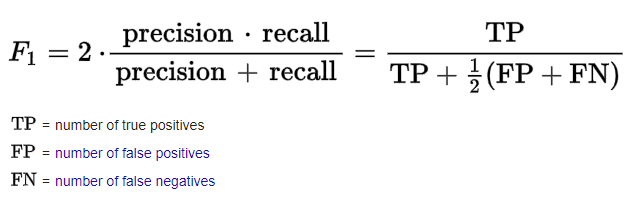

<b> Un score F1 plus grand implique une précision ET recall plus grands<b>

In [7]:
# Bruit uniforme à 30%
X_dirty_2,y_dirty_2=UniformNoise(noise_level=0.3 # Bruit 30%
                             ,random_state=1).fit_transform(X_clean.copy(),y_clean.copy())

### Division Train/Test 

In [251]:
#Division en Train & Test stratifiée, on n'utilise pas la cv sur du "unsupervised learning"
# Dirty
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_dirty_2, y_dirty_2,stratify=y_dirty_2, test_size=0.5, random_state=1)


In [10]:
# Clean
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clean, y_clean,stratify=y_clean, test_size=0.5, random_state=1)


## Modèles basés sur les Ensembles & Combination 

### Isolation Forest

Renvoie le score d'anomalie de chaque échantillon en utilisant l'algorithme IsolationForest

La forêt d'isolement "isole" les observations en sélectionnant au hasard une caractéristique, puis en choisissant au hasard une valeur fractionnée entre les valeurs maximale et minimale de la caractéristique sélectionnée.

Comme le partitionnement récursif peut être représenté par une structure arborescente, le nombre de fractionnements requis pour isoler un échantillon est équivalent à la longueur du chemin du nœud racine au nœud terminal.

Cette longueur de chemin, dont la moyenne est calculée sur une forêt de tels arbres aléatoires, est une mesure de normalité et notre fonction de décision.

Le partitionnement aléatoire produit des chemins sensiblement plus courts pour les anomalies. Par conséquent, lorsqu'une forêt d'arbres aléatoires produit collectivement des chemins plus courts pour des échantillons particuliers, il est très probable qu'il s'agisse d'anomalies.



In [11]:
isof = IsolationForest(contamination=0.3)
isof.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = isof.predict(X_test_d)
# On code les inliers 1, outliers -1
y_test_bi=LabelEncoder().fit_transform(y_test_c)
y_test_bi[y_test_bi == 1] = -1
y_test_bi[y_test_bi == 0] = 1
# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.547


### Extended Isolation Forest

<b>J'ai utilisé une regression logistique pour définir une frontière de décision entre les probabilités définies par l'EIF<b>

In [261]:
X_train_ex,X_train_lr=X_train_d[:int(len(X_train_d)*0.5)],X_train_d[int(len(X_train_d)*0.5):]
X_test_ex,X_test_lr=X_test_d[:int(len(X_test_d)*0.5)],X_test_d[int(len(X_test_d)*0.5):]
ex_isof=eif.iForest(X_train_ex, ntrees=200,sample_size=165, ExtensionLevel=2)
X_train_l=ex_isof.compute_paths(X_in=X_train_lr)
X_test_l=ex_isof.compute_paths(X_in=X_test_d)


In [263]:
lr=LogisticRegression(C=0.6,random_state=1)
lr.fit(X_train_l.reshape(-1,1),y_train_d[int(len(X_train_d)*0.5):].reshape(-1,1))
yhat=lr.predict(X_test_l.reshape(-1,1))

# On score avec F1
score = f1_score(y_test_c, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.567


### Feature Bagging

In [278]:
fb=FeatureBagging(LOF(n_neighbors=57, contamination=0.3),
                       contamination=0.3,
                       random_state=1)
fb.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = fb.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.246


### LSCP-Locally Selective Combination 

In [283]:
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50),LOF(n_neighbors=57),LOF(n_neighbors=67),LOF(n_neighbors=75)]

lscp=LSCP(detector_list, contamination=0.3,random_state=1)
lscp.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = lscp.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.266


In [425]:
detector_list = [LOF(n_neighbors=57),OCSVM(contamination=0.3),]

lscp=LSCP(detector_list, contamination=0.3,random_state=1)
lscp.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = lscp.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.345


## Modèles Linéaires

### PCA- Principal Component Analysis

PCA utilise la somme des distances projetées pondérées par rapport à l'hyperplan du vecteur propre comme scores des valeurs aberrantes)

In [93]:
pca = PCA(contamination=0.3,random_state=1)
pca.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = pca.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.254


### MCD-Minimum Covariance Determinant

Utilise la distance de Mahalanobis(robustesse à la covariance des features) pour le scoring des outliers

In [98]:
mcd = MCD(contamination=0.3,random_state=1)
mcd.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = mcd.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.258


### OCSVM- One-Class Support Vector Machines

In [101]:
ocsvm = OCSVM(contamination=0.3)
ocsvm.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = ocsvm.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.324


### LMDD-Linear Model Deviation-base outlier detection 

’aad’: Average Absolute Deviation

’var’: Variance

’iqr’: Interquartile Range

In [290]:
lmdd= LMDD(contamination=0.3, n_iter=50, dis_measure='aad', random_state=1)
lmdd.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = lmdd.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.196


In [291]:
lmdd= LMDD(contamination=0.3, n_iter=50, dis_measure='var', random_state=1)
lmdd.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = lmdd.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.199


In [292]:
lmdd= LMDD(contamination=0.3, n_iter=50, dis_measure='iqr', random_state=1)
lmdd.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = lmdd.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.080


## Modèles basés sur la proximité

### LOF-Local Outlier Factor

In [179]:
lof = LOF(n_neighbors=57, contamination=0.3)
lof.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = lof.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.242


### CBLOF-Clustering-Based Local Outlier Factor

In [201]:
cblof = CBLOF(random_state=1,check_estimator=False, contamination=0.3)
cblof.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = cblof.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.307


### Median kNN

In [285]:
mknn = KNN(method='median', contamination=0.3)
mknn.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = mknn.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.293


### Average kNN

In [287]:
aknn = KNN(method='mean', contamination=0.3)
aknn.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = aknn.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.282


### HBOS-Histogram-based Outlier Score

In [187]:
hbos = HBOS(contamination=0.3)
hbos.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = hbos.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.273


### SOD-Subspace Outlier Detection 

In [417]:
sod = SOD(contamination=0.3,n_neighbors=57, ref_set=3, alpha=0.8)
sod.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = sod.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.292


## Modèles probabilistes

### ABOD: Angle-Based Outlier Detection

In [373]:
X=X_train_ex.copy()
X = X.astype('float64') # Problème avec dtype 
abod = ABOD(contamination=0.3)
abod.fit(X)

Xt=X_test_d.copy().astype('float64')
Xc=X_train_lr.copy().astype('float64')
X_train_ll=abod.decision_function(X_train_lr)
X_test_ll=abod.decision_function(X_test_d)


In [374]:
lr=LogisticRegression(C=0.6,random_state=1)
X2=SimpleImputer(missing_values=np.nan,strategy="median").fit_transform(X_train_ll.reshape(-1, 1))
X3=SimpleImputer(missing_values=np.nan,strategy="median").fit_transform(X_test_ll.reshape(-1, 1))
lr.fit(X2.reshape(-1,1),y_train_d[int(len(X_train_d)*0.5):].reshape(-1,1))
yhat=lr.predict(X3.reshape(-1,1))

# On score avec F1
score = f1_score(y_test_c, yhat,average="weighted")
print('F1 Score: %.3f' % score)



F1 Score: 0.517


### COPOD - Copula Based Outlier Detector 

In [299]:
mad = COPOD(contamination=0.3)
mad.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = mad.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.264


### SOS-Stochastic Outlier Selection 

In [369]:
sos = SOS(contamination=0.3,perplexity=35, metric='euclidean', eps=2)
sos.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = sos.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

F1 Score: 0.303


## Neural Networks

### Single-Objective Generative Adversarial Active Learning

In [480]:
sog=SO_GAAL(stop_epochs=30, lr_d=0.0001, lr_g=0.00001, decay=0.7, contamination=0.3)
sog.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = sog.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

Epoch 1 of 90

Testing for epoch 1 index 1:
Epoch 2 of 90

Testing for epoch 2 index 1:
Epoch 3 of 90

Testing for epoch 3 index 1:
Epoch 4 of 90

Testing for epoch 4 index 1:
Epoch 5 of 90

Testing for epoch 5 index 1:
Epoch 6 of 90

Testing for epoch 6 index 1:
Epoch 7 of 90

Testing for epoch 7 index 1:
Epoch 8 of 90

Testing for epoch 8 index 1:
Epoch 9 of 90

Testing for epoch 9 index 1:
Epoch 10 of 90

Testing for epoch 10 index 1:
Epoch 11 of 90

Testing for epoch 11 index 1:
Epoch 12 of 90

Testing for epoch 12 index 1:
Epoch 13 of 90

Testing for epoch 13 index 1:
Epoch 14 of 90

Testing for epoch 14 index 1:
Epoch 15 of 90

Testing for epoch 15 index 1:
Epoch 16 of 90

Testing for epoch 16 index 1:
Epoch 17 of 90

Testing for epoch 17 index 1:
Epoch 18 of 90

Testing for epoch 18 index 1:
Epoch 19 of 90

Testing for epoch 19 index 1:
Epoch 20 of 90

Testing for epoch 20 index 1:
Epoch 21 of 90

Testing for epoch 21 index 1:
Epoch 22 of 90

Testing for epoch 22 index 1:
Epoch 

In [481]:
print('F1 Score: %.3f' % score)

F1 Score: 0.263


### Multiple-Objective Generative Adversarial Active Learning

In [472]:
mog=MO_GAAL(k=10, stop_epochs=30, lr_d=0.0001, lr_g=0.0001, decay=0.7, contamination=0.3)
mog.fit(X_train_d)

# On détecte les anomalies sur le test set
yhat = mog.predict(X_test_d)

# On score avec F1
score = f1_score(y_test_bi, yhat,average="weighted")
print('F1 Score: %.3f' % score)

Epoch 1 of 90

Testing for epoch 1 index 1:


Epoch 2 of 90

Testing for epoch 2 index 1:
Epoch 3 of 90

Testing for epoch 3 index 1:
Epoch 4 of 90

Testing for epoch 4 index 1:
Epoch 5 of 90

Testing for epoch 5 index 1:
Epoch 6 of 90

Testing for epoch 6 index 1:
Epoch 7 of 90

Testing for epoch 7 index 1:
Epoch 8 of 90

Testing for epoch 8 index 1:
Epoch 9 of 90

Testing for epoch 9 index 1:
Epoch 10 of 90

Testing for epoch 10 index 1:
Epoch 11 of 90

Testing for epoch 11 index 1:
Epoch 12 of 90

Testing for epoch 12 index 1:
Epoch 13 of 90

Testing for epoch 13 index 1:
Epoch 14 of 90

Testing for epoch 14 index 1:
Epoch 15 of 90

Testing for epoch 15 index 1:
Epoch 16 of 90

Testing for epoch 16 index 1:
Epoch 17 of 90

Testing for epoch 17 index 1:
Epoch 18 of 90

Testing for epoch 18 index 1:
Epoch 19 of 90

Testing for epoch 19 index 1:
Epoch 20 of 90

Testing for epoch 20 index 1:
Epoch 21 of 90

Testing for epoch 21 index 1:
Epoch 22 of 90

Testing for epoch 22 index 1:
Epoch 23 of 90

Testing for epoch 23 index 1:
Epoc

11/11 [==============================] - 0s 1000us/step - loss: 0.5934
Epoch 49 of 90

Testing for epoch 49 index 1:
11/11 [==============================] - 0s 1ms/step - loss: 0.5892
Epoch 50 of 90

Testing for epoch 50 index 1:
11/11 [==============================] - 0s 1ms/step - loss: 0.5906
Epoch 51 of 90

Testing for epoch 51 index 1:
11/11 [==============================] - 0s 1ms/step - loss: 0.5940
Epoch 52 of 90

Testing for epoch 52 index 1:
11/11 [==============================] - 0s 1ms/step - loss: 0.5953
Epoch 53 of 90

Testing for epoch 53 index 1:
11/11 [==============================] - 0s 1ms/step - loss: 0.5921
Epoch 54 of 90

Testing for epoch 54 index 1:
11/11 [==============================] - 0s 1ms/step - loss: 0.5964
Epoch 55 of 90

Testing for epoch 55 index 1:
11/11 [==============================] - 0s 1ms/step - loss: 0.5953
Epoch 56 of 90

Testing for epoch 56 index 1:
11/11 [==============================] - 0s 903us/step - loss: 0.5960
Epoch 57 of 90


11/11 [==============================] - 0s 1ms/step - loss: 0.5982
Epoch 71 of 90

Testing for epoch 71 index 1:
11/11 [==============================] - 0s 1ms/step - loss: 0.5990
Epoch 72 of 90

Testing for epoch 72 index 1:
11/11 [==============================] - 0s 3ms/step - loss: 0.5916
Epoch 73 of 90

Testing for epoch 73 index 1:
11/11 [==============================] - 0s 1ms/step - loss: 0.5822
Epoch 74 of 90

Testing for epoch 74 index 1:
11/11 [==============================] - 0s 1ms/step - loss: 0.5778
Epoch 75 of 90

Testing for epoch 75 index 1:
11/11 [==============================] - 0s 1ms/step - loss: 0.5898
Epoch 76 of 90

Testing for epoch 76 index 1:
11/11 [==============================] - 0s 1ms/step - loss: 0.5898
Epoch 77 of 90

Testing for epoch 77 index 1:
11/11 [==============================] - 0s 1ms/step - loss: 0.5898
Epoch 78 of 90

Testing for epoch 78 index 1:
11/11 [==============================] - 0s 1000us/step - loss: 0.5847
Epoch 79 of 90

T

In [473]:
print('F1 Score: %.3f' % score)

F1 Score: 0.284
